In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Read Data

In [53]:
train_data = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test_data = np.loadtxt('test.csv', delimiter=',', skiprows=1)

## Split on training pairs

In [58]:
labels = train_data[:,0].astype(np.int32)
X_train = train_data[:,1:]

## Normalization

In [55]:
X_train = X_train / 255.
X_test = test_data / 255.

### To categorical

In [63]:
N_CLASSES = np.unique(labels).size

In [162]:
y_train = np.eye(OUTPUT_SIZE, dtype='int32')[labels]

## Perceptron

- посмотреть в вольфрам альфа
- проверить на графике

In [814]:
# sigmoid activation
def sigmoid(x):
    return 1/(1+np.exp(-x))

# sigmoid derivative
def sigmoid_derivative(x):
   # exp = np.exp(x)
    return sigmoid(x)*(1-sigmoid(x))#exp/np.square(exp+1)

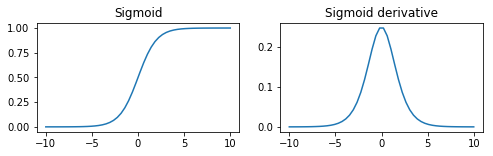

In [815]:
# test sigmoid and it's derivative
test_arr = np.linspace(-10, 10)

plt.figure(figsize=(8, 2))

ax1 = plt.subplot(121)
ax1.set_title('Sigmoid')
ax1.plot(test_arr, sigmoid(test_arr))

ax2 = plt.subplot(122)
ax2.set_title('Sigmoid derivative')
ax2.plot(test_arr, sigmoid_derivative(test_arr))

plt.show()

## Cross entropy

In [816]:
def categorical_crossentropy(y_pred, y):
    """ y_pred - logits
        y - labels
    """
    # y > 0
    pos = -y*np.log(y_pred)
    # y < 0
    neg = -(1-y)*np.log(1-y_pred)
    # loss over every sample
    cost = np.sum(np.nan_to_num(pos+neg), axis=1)
    # we should return mean value
    return np.mean(cost)

def categorical_crossentropy_derivative(y_pred, y):
    """ y_pred - logits
        y - labels
    """
    return y_pred-y

In [817]:
# test entropy
test_arr_x = np.zeros(10, dtype=np.int32)
test_arr_x[5:] = labels[5:10].copy()
test_arr_x = np.eye(N_CLASSES, dtype='int32')[test_arr_x]
test_arr_x = test_arr_x*0.99+0.00001

test_arr_z = y_train[:10].copy()
categorical_crossentropy(test_arr_x[:5], test_arr_z[:5])

9.6755577851529093

### Weight initializer

In [818]:
def init_weights(sizes):
    # sizes is a number of neurons per layer
    # first layer is input and dont need any weights
    b = [np.random.randn(1,y) for y in sizes[1:]]
    # weights
    # sizes[:-1] - every except last
    # sizes[1:] - every except first
    # zip creates generator
    W = [np.random.randn(y, x)/np.sqrt(x) 
            for x, y in zip(sizes[1:], sizes[:-1])]
    
    return (W, b)

In [819]:
W,b = init_weights([784,10])

print('Weight shapes:', [w.shape for w in W])
print('Bias shapes:', [b_.shape for b_ in b])
print('Bias:')
print(b[0])

Weight shapes: [(784, 10)]
Bias shapes: [(1, 10)]
Bias:
[[-0.2070955   0.90553585 -0.18191227  0.03614635  1.53541432  0.43635876
   0.84173953  1.68904045  1.4465627   1.83645465]]


### Forward pass

In [820]:
def feedprop(x, W, b):
    """Return the output of 
    the network if ``x`` is input.
    W - weights
    b - biases
    
    Return a, z, act
        a - array, predicted value
        zs - list, variable that stores 
            all neuron info for every layer
        acts - list, all activations for every layer
              including input
    """
    a = x
    acts = [a] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer

    for w,b_ in zip(W, b):
        z = np.dot(a, w) + b_
        zs.append(z)
        # apply activation
        a = sigmoid(z)
        acts.append(a)
    y_pred = a
    return y_pred, zs, acts

In [821]:
# test feed forward pass
# create network parameters
W,b = init_weights([784,100,10])
# get predictions
pred = feedprop(X_train, W, b)[0]
print('Prediction shape:', pred.shape)
print('First prediction:', np.argmax(pred[0]))
print('Cost with random weights:', categorical_crossentropy(pred, y_train))

Prediction shape: (42000, 10)
First prediction: 0
Cost with random weights: 6.20253742296


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


### We need some accuracy metric

In [822]:
def accuracy(x,y,W,b):
    '''x - network inputs
       y - labels
    '''
    y_pred = feedprop(x,W,b)[0]
    y_pred = np.argmax(y_pred, axis=1)
    y = np.argmax(y, axis=1)
    acc = np.equal(y_pred, y)
    acc = np.mean(acc)
    return acc

In [823]:
# test feed forward pass
# create network parameters
W,b = init_weights([784,100,10])
# get predictions
pred = feedprop(X_train, W, b)[0]
print('Prediction shape:', pred.shape)
print('First prediction:', np.argmax(pred[0]))
print('Cost with random weights:', categorical_crossentropy(pred, y_train))
acc = accuracy(X_train, y_train, W, b)
print('Accuracy:', acc)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Prediction shape: (42000, 10)
First prediction: 2
Cost with random weights: 18.2346592138
Accuracy: 0.109595238095


### Backward pass

In [843]:
def backprop(x, y, W, b):
    '''(x,y) - one learning pair
       W - weights
       b - biases
    '''
    # variables for storing gradients
    grad_b = [np.zeros_like(b_) for b_ in b]
    grad_W = [np.zeros_like(w) for w in W]
    
    # forward pass
    # predicted value, neurons values, activations
    y_pred, zs, acts = feedprop(x, W, b)
    # reshape to matrix
    if len(acts[0].shape) == 1:
        acts[0] = np.expand_dims(acts[0], axis=1)
    # compute error for last layer
    e = categorical_crossentropy_derivative(y_pred, y)
    #e = e*sigmoid_derivative(zs[-1])
    grad_b[-1] = e
    grad_W[-1] = np.dot(acts[-2].T, e) # we dont need last activation
    # loop back over layers
    n_layers = len(b)+1
    for l in range(2, n_layers):
        z = zs[-l]
        # gradient for sigmoid
        sigmoid_grad = sigmoid_derivative(z)
        e = np.dot(e, W[-l+1].T) * sigmoid_grad
        grad_b[-l] = e
        grad_W[-l] = np.dot(acts[-l-1], e)
        
    return grad_W, grad_b

In [849]:
for x,y in zip(X_train[:10],y_train[:10]):
    grad_W, grad_b = backprop(x, y, W, b)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


### Let's do Gradient Descent

In [868]:
def GD(X_train, y_train, W, b, epochs, learning_rate):
    for i in range(epochs):
        delta_W = [np.zeros_like(w) for w in W]
        delta_b = [np.zeros_like(b_) for b_ in b]
        
        for x,y in zip(X_train, y_train):
            grad_W, grad_b = backprop(x,y,W,b)
            
            for l in range(len(b)):
                # compute delta
                delta_W[l] += grad_W[l]
                delta_b[l] += grad_b[l]
                
        for l in range(len(b)):
            W[l] = W[l] - (learning_rate/len(X_train))*delta_W[l]
            b[l] = b[l] - (learning_rate/len(X_train))*delta_b[l]
                
        # metric
        #print([w.shape for w in W])
        #print([b_.shape for b_ in b])
        
        train_acc = accuracy(X_train, y_train, W, b)
        print('Epoch {} Accuracy: {}'.format(i, train_acc))
    
    return W,b

In [884]:
W,b = init_weights([X_train.shape[1],30,N_CLASSES])

In [885]:
W,b = GD(X_train, y_train, W, b, 50, 0.8)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 0 Accuracy: 0.08542857142857142
Epoch 1 Accuracy: 0.1345952380952381
Epoch 2 Accuracy: 0.21723809523809523
Epoch 3 Accuracy: 0.29678571428571426
Epoch 4 Accuracy: 0.35604761904761906
Epoch 5 Accuracy: 0.3887857142857143
Epoch 6 Accuracy: 0.4180238095238095
Epoch 7 Accuracy: 0.4504761904761905
Epoch 8 Accuracy: 0.4855238095238095
Epoch 9 Accuracy: 0.5050714285714286
Epoch 10 Accuracy: 0.5241666666666667
Epoch 11 Accuracy: 0.5490952380952381
Epoch 12 Accuracy: 0.5598095238095238
Epoch 13 Accuracy: 0.5618571428571428
Epoch 14 Accuracy: 0.5806428571428571
Epoch 15 Accuracy: 0.5988809523809524
Epoch 16 Accuracy: 0.6019761904761904
Epoch 17 Accuracy: 0.6240238095238095
Epoch 18 Accuracy: 0.6312619047619048
Epoch 19 Accuracy: 0.6386190476190476
Epoch 20 Accuracy: 0.6586904761904762
Epoch 21 Accuracy: 0.661047619047619
Epoch 22 Accuracy: 0.6806666666666666
Epoch 23 Accuracy: 0.6765238095238095
Epoch 24 Accuracy: 0.6913333333333334
Epoch 25 Accuracy: 0.6931904761904762
Epoch 26 Accuracy: 